<h1 style="text-align:center;font-size:30px;" > Quora Question Pairs </h1>

## Contents

#### [1] Business Problem
#### [2] Machine Learning Problem
#### [3] Exploratory Data Analysis
#### [4] Machine Learning Models
#### [5] Conclusion

<h1> 1. Business Problem </h1>

<h2> 1.1 Description </h2>

<p>Quora is a place to gain and share knowledge about anything. It’s a platform to ask questions and connect with people who contribute unique insights and quality answers. This empowers people to learn from each other and to better understand the world.</p>
<p>
Over 100 million people visit Quora every month, so it's no surprise that many people ask similarly worded questions. Multiple questions with the same intent can cause seekers to spend more time finding the best answer to their question, and make writers feel they need to answer multiple versions of the same question. Quora values canonical questions because they provide a better experience to active seekers and writers, and offer more value to both of these groups in the long term.
</p>
<br>
> Credits: Kaggle 


<b> Problem Statement </b>
- Identify which questions asked on Quora are duplicates of questions that have already been asked. 
- This could be useful to instantly provide answers to questions that have already been answered. 
- We are tasked with predicting whether a pair of questions are duplicates or not. 

<h2> 1.2 Sources/Useful Links</h2>

- Source : https://www.kaggle.com/c/quora-question-pairs
<br><br>____ Useful Links ____
- Discussions : https://www.kaggle.com/anokas/data-analysis-xgboost-starter-0-35460-lb/comments
- Kaggle Winning Solution and other approaches: https://www.dropbox.com/sh/93968nfnrzh8bp5/AACZdtsApc1QSTQc7X0H3QZ5a?dl=0
- Blog 1 : https://engineering.quora.com/Semantic-Question-Matching-with-Deep-Learning
- Blog 2 : https://towardsdatascience.com/identifying-duplicate-questions-on-quora-top-12-on-kaggle-4c1cf93f1c30

<h2>1.3 Real world/Business Objectives and Constraints </h2>

1. The cost of a mis-classification can be very high.
2. You would want a probability of a pair of questions to be duplicates so that you can choose any threshold of choice.
3. No strict latency concerns.
4. Interpretability is partially important.

<h1>2. Machine Learning Probelm </h1>

<h2> 2.1 Data </h2>

<h3> 2.1.1 Data Overview </h3>

<p> 
- Data will be in a file Train.csv <br>
- Train.csv contains 5 columns : qid1, qid2, question1, question2, is_duplicate <br>
- Size of Train.csv - 60MB <br>
- Number of rows in Train.csv = 404,290
</p>

<h3> 2.1.2 Example Data point </h3>

<pre>
"id","qid1","qid2","question1","question2","is_duplicate"
"0","1","2","What is the step by step guide to invest in share market in india?","What is the step by step guide to invest in share market?","0"
"1","3","4","What is the story of Kohinoor (Koh-i-Noor) Diamond?","What would happen if the Indian government stole the Kohinoor (Koh-i-Noor) diamond back?","0"
"7","15","16","How can I be a good geologist?","What should I do to be a great geologist?","1"
"11","23","24","How do I read and find my YouTube comments?","How can I see all my Youtube comments?","1"
</pre>

<h2> 2.2 Mapping the real world problem to an ML problem </h2>

<h3> 2.2.1 Type of Machine Leaning Problem </h3>

<p> It is a binary classification problem, for a given pair of questions we need to predict if they are duplicate or not. </p>

<h3> 2.2.2 Performance Metric </h3>

Source: https://www.kaggle.com/c/quora-question-pairs#evaluation

Metric(s): 
* log-loss : https://www.kaggle.com/wiki/LogarithmicLoss
* Binary Confusion Matrix

<h2> 2.3 Train and Test Construction </h2>

<p>  </p>
<p> We build train, cv and test by randomly splitting in the ratio of 70:15:15 or 80:20:20 whatever we choose as we have sufficient points to work with. </p>

<h1>3. Exploratory Data Analysis </h1>

In [4]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup
import distance
from sklearn.manifold import TSNE
from wordcloud import WordCloud, STOPWORDS
from fuzzywuzzy import fuzz
from sklearn.feature_extraction.text import TfidfVectorizer


import warnings
warnings.filterwarnings('ignore')


%matplotlib inline

<h2> 3.1 Reading data and basic stats </h2>

In [2]:
df = pd.read_csv('train.csv')
print(f"Number of rows in the data : {df.shape[0]}")
print(f"Columns in the data : {df.columns}")

Number of rows in the data : 404290
Columns in the data : Index(['id', 'qid1', 'qid2', 'question1', 'question2', 'is_duplicate'], dtype='object')


In [3]:
df.head()

id  qid1  qid2                                          question1  \
0   0     1     2  What is the step by step guide to invest in sh...   
1   1     3     4  What is the story of Kohinoor (Koh-i-Noor) Dia...   
2   2     5     6  How can I increase the speed of my internet co...   
3   3     7     8  Why am I mentally very lonely? How can I solve...   
4   4     9    10  Which one dissolve in water quikly sugar, salt...   

                                           question2  is_duplicate  
0  What is the step by step guide to invest in sh...             0  
1  What would happen if the Indian government sto...             0  
2  How can Internet speed be increased by hacking...             0  
3  Find the remainder when [math]23^{24}[/math] i...             0  
4            Which fish would survive in salt water?             0

In [4]:
#printing the info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
id              404290 non-null int64
qid1            404290 non-null int64
qid2            404290 non-null int64
question1       404289 non-null object
question2       404288 non-null object
is_duplicate    404290 non-null int64
dtypes: int64(4), object(2)
memory usage: 18.5+ MB



<pre>
Here, We are given a minimal number of data fields here, consisting of:


- id              :  Looks like a simple rowID
- qid{1, 2}       :  The unique ID of each question in the pair
- question{1, 2}  :  The actual textual contents of the questions.
- is_duplicate    :  The label that we are trying to predict - whether the two questions are duplicates of each other.
</pre>

<h3> 3.2.1 Checking for NULL values </h3>

In [5]:
nan_rows = df[df.isnull().any(1)]
print(f"Number of null valued rows : {nan_rows.shape[0]}")

Number of null valued rows : 3


In [6]:
nan_rows

id    qid1    qid2                         question1  \
105780  105780  174363  174364    How can I develop android app?   
201841  201841  303951  174364  How can I create an Android app?   
363362  363362  493340  493341                               NaN   

                                                question2  is_duplicate  
105780                                                NaN             0  
201841                                                NaN             0  
363362  My Chinese name is Haichao Yu. What English na...             0

In [7]:
#drop the rows with null values
df = df.dropna()
print(f"Number of null valued rows : {df[df.isnull().any(1)].shape[0]}")

Number of null valued rows : 0


In [8]:
#change/fix datatypes of the columns
df = df.astype({'id':int, 'qid1':int, 'qid2':int, 'question1':str, 'question2':str, 'is_duplicate':bool})

<h3>3.2.2 Checking for Duplicates </h3>

In [9]:
#checking whether there are any repeated pair of questions

pair_duplicates = df[['qid1','qid2','is_duplicate']].groupby(['qid1','qid2']).count().reset_index()
print(f"Number of duplicate questions : {pair_duplicates.shape[0] - df.shape[0]}")

Number of duplicate questions : 0


<h3> 3.2.3 Distribution of data points among output classes</h3>

- Number of duplicate(similar) and non_duplicate(non similar) questions

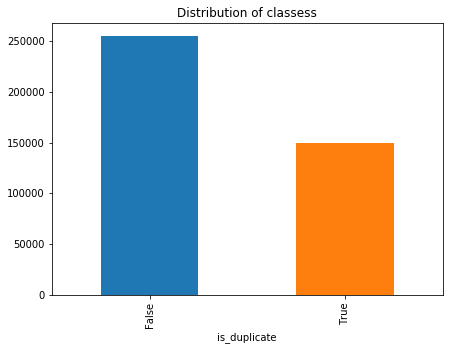

In [10]:
df.groupby(['is_duplicate'])['id'].count().plot(kind='bar', title='Distribution of classess', figsize=(7, 5))

In [11]:
print(f'~> Total number of question pairs for training  :  {len(df)}')

~> Total number of question pairs for training  :  404287


In [12]:
print(f"~> Question pairs that are duplicate     : {df['is_duplicate'].mean() * 100 : .2f}%")
print(f"~> Question pairs that are not duplicate : {100 - df['is_duplicate'].mean() * 100 : .2f}%")

~> Question pairs that are duplicate     :  36.92%
~> Question pairs that are not duplicate :  63.08%


~> The 'not_duplicate' class seems be to dominant with 63%. The dataset is slightly imbalanced.

<h3> 3.2.4 Number of unique questions </h3>

In [13]:
qids = pd.Series(df['qid1'].tolist() + df['qid2'].tolist())
q_vals = qids.value_counts()
q_vals = q_vals.values
unique_qs = len(np.unique(qids))
rep_qs = np.sum(qids.value_counts() > 1)

print(f'Total number of  Unique Questions are: {unique_qs}\n')
print(f'Number of unique questions that are repeated : {rep_qs} ({rep_qs/unique_qs*100 : .2f}%)\n')
print(f'Max number of times a single question is repeated : {max(qids.value_counts())}\n')
print(f"The most repeated question is : {df[df['qid1'] == qids.value_counts().idxmax()]['question1'].values[0]}")


Total number of  Unique Questions are: 537929

Number of unique questions that are repeated : 111778 ( 20.78%)

Max number of times a single question is repeated : 157

The most repeated question is : What are the best ways to lose weight?


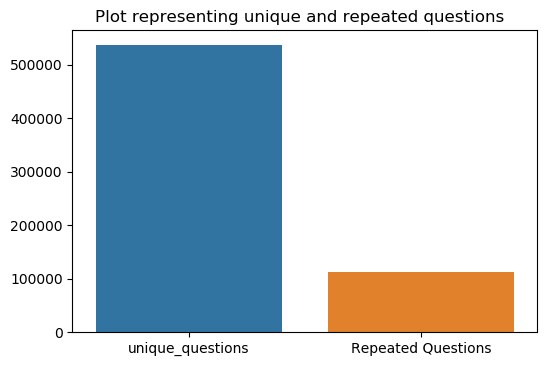

In [14]:
x = ["unique_questions" , "Repeated Questions"]
y =  [unique_qs , rep_qs]

plt.figure(dpi=100)
plt.title ("Plot representing unique and repeated questions  ")
sns.barplot(x, y)
plt.show()

<h3> 3.2.4 Number of occurrences of each question </h3>

Max number of times a single question is repeated : 157


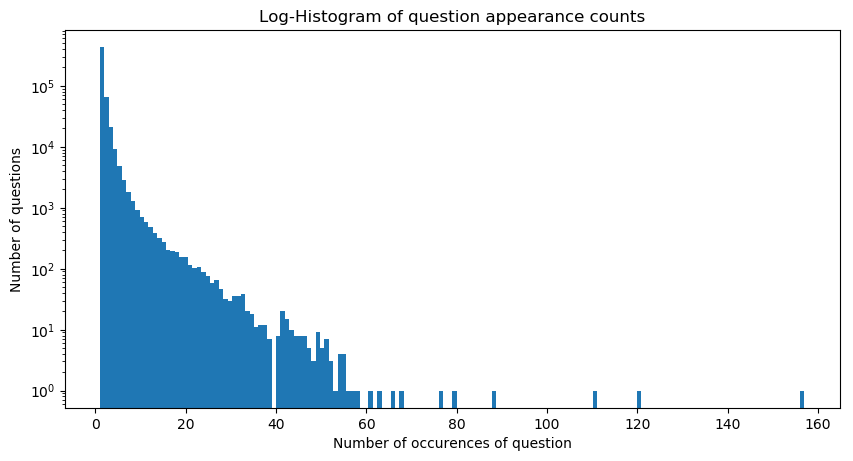

In [15]:
plt.figure(figsize=(10, 5), dpi=100)
plt.hist(qids.value_counts(), bins=160)
plt.yscale('log', nonposy='clip')
plt.title('Log-Histogram of question appearance counts')
plt.xlabel('Number of occurences of question')
plt.ylabel('Number of questions')
print(f'Max number of times a single question is repeated : {max(qids.value_counts())}') 

___Log Histogram___

* The horizontal axis(number of occurences of question) tells us that the occurence of a question decreases from left to right(->)
* The vertical axis(number of questions) tells us that many questions have frequency (1,..5). Very few times the questions are repeated more than ~60 times.

<h2>3.3 Basic Feature Extraction (before cleaning) </h2>

Let us now construct a few features like:
 - ____freq_qid1____       = Frequency of qid1's
 - ____freq_qid2____       = Frequency of qid2's 
 - ____q1_len____          = Length of q1
 - ____q2_len____          = Length of q2
 - ____q1_n_words____      = Number of words in Question 1
 - ____q2_n_words____      = Number of words in Question 2
 - ____words_common____    = (Number of common unique words in Question 1 and Question 2)
 - ____words_total____     =(Total num of words in Question 1 + Total num of words in Question 2)
 - ____words_shared____    = (word_common)/(word_Total)
 - ____freq_q1+freq_q2____ = sum total of frequency of qid1 and qid2 
 - ____freq_q1-freq_q2____ = absolute difference of frequency of qid1 and qid2 

In [16]:
def normalized_words_common(row):
    w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
    return 1.0 * len(w1 & w2)

def normalized_words_total(row):
    w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" "))) 
    return 1.0 * len(w1.union(w2))

def normalized_words_shared(row):
    words_common = normalized_words_common(row)
    words_total = normalized_words_total(row)
    return words_common / words_total


In [17]:
#building the features above
df['freq_qid1'] = df.groupby('qid1')['qid1'].transform('count')
df['freq_qid2'] = df.groupby('qid2')['qid2'].transform('count')
df['q1_len'] = df['question1'].str.len()
df['q2_len'] = df['question2'].str.len()
df['q1_n_words'] = df['question1'].apply(lambda text : len(text.strip().split()))
df['q2_n_words'] = df['question2'].apply(lambda text : len(text.strip().split()))
df['words_common'] = df.apply(normalized_words_common, axis=1)
df['words_total'] = df.apply(normalized_words_total, axis=1)
df['words_shared'] = df.apply(normalized_words_shared, axis=1)
df['freq_q1+q2'] = df['freq_qid1'] + df['freq_qid2']
df['freq_q1-q2'] = np.abs(df['freq_qid1'] - df['freq_qid2'])

In [18]:
#save to disk
df.to_csv("basic_features_train.csv", index=False)

In [19]:
df.head(2)

id  qid1  qid2                                          question1  \
0   0     1     2  What is the step by step guide to invest in sh...   
1   1     3     4  What is the story of Kohinoor (Koh-i-Noor) Dia...   

                                           question2  is_duplicate  freq_qid1  \
0  What is the step by step guide to invest in sh...         False          1   
1  What would happen if the Indian government sto...         False          4   

   freq_qid2  q1_len  q2_len  q1_n_words  q2_n_words  words_common  \
0          1      66      57          14          12          10.0   
1          1      51      88           8          13           4.0   

   words_total  words_shared  freq_q1+q2  freq_q1-q2  
0         13.0      0.769231           2           0  
1         16.0      0.250000           5           3

<h3> 3.3.1 Analysis of some of the extracted features </h3>

In [20]:
print(f"least number of words in question1 : {df['q1_n_words'].min()}")
print(f"least number of words in question2 : {df['q2_n_words'].min()}\n")

print(f"Number of rows with only one word in question1 : {(df['q1_n_words'] == 1).sum()}")
print(f"Number of rows with only one word in question2 : {(df['q2_n_words'] == 1).sum()}")

least number of words in question1 : 1
least number of words in question2 : 1

Number of rows with only one word in question1 : 69
Number of rows with only one word in question2 : 25


<h4> 3.3.1.1 Feature : words_shared </h4>

In [21]:
print(f"Average number of words shared by duplicate questions     : {df[df['is_duplicate'] == True]['words_shared'].mean()*100 : .2f}%")
print(f"Average number of words shared by non duplicate questions : {df[df['is_duplicate'] == False]['words_shared'].mean()*100 : .2f}%")

Average number of words shared by duplicate questions     :  43.09%
Average number of words shared by non duplicate questions :  26.44%


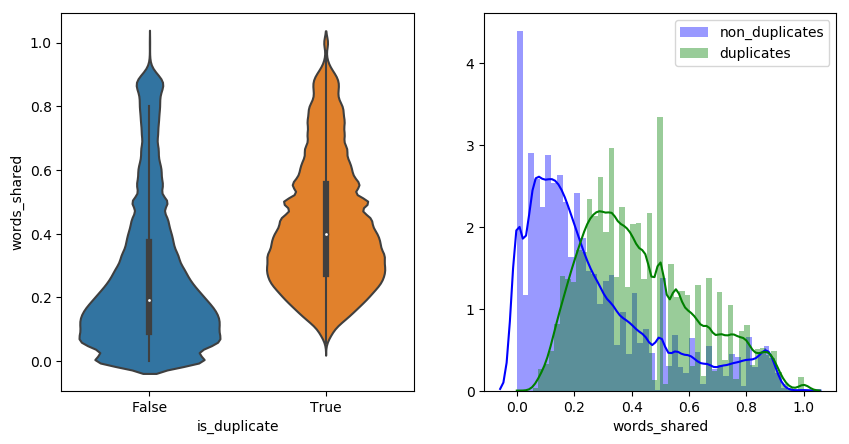

In [22]:
plt.figure(figsize=(10, 5), dpi=100)

plt.subplot(1, 2, 1)
sns.violinplot(x='is_duplicate', y='words_shared', data=df)

plt.subplot(1, 2, 2)
sns.distplot(df[df['is_duplicate'] == False]['words_shared'], label='non_duplicates', color='blue')
sns.distplot(df[df['is_duplicate'] == True]['words_shared'], label='duplicates', color='green')

plt.legend()

__Obseravations__

* The violin plot shows that the avg_words_shared value is more when the pair(q1, q2) are duplicates.
* In the distribution plot, both the distributions(duplicates, non_duplicates) have some overlap.
* The duplicate pairs have high variance and is fatter indicating lot of duplicates have shared words.
* The non_duplicates pairs have less words in common and the distribution is thinner with less variance.

<h4> 3.3.1.2 Feature : words_common </h4>

In [23]:
print(f"Average number of common words for duplicate questions     : {df[df['is_duplicate'] == True]['words_common'].median() : .2f}")
print(f"Average number of common words for non duplicate questions : {df[df['is_duplicate'] == False]['words_common'].median() : .2f}")

Average number of common words for duplicate questions     :  5.00
Average number of common words for non duplicate questions :  3.00


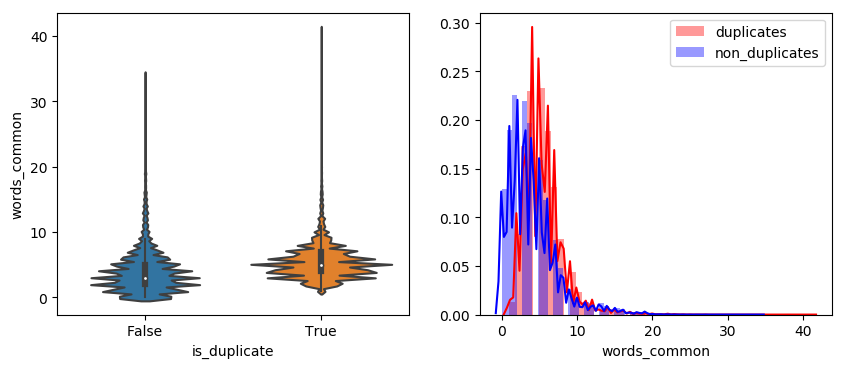

In [24]:
plt.figure(figsize=(10, 4), dpi=100)

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'words_common', data = df)

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == True]['words_common'], label = "duplicates", color = 'red')
sns.distplot(df[df['is_duplicate'] == False]['words_common'], label = "non_duplicates" , color = 'blue')

plt.legend()
plt.show()

__Observations__

* Both the distributions have high overlap, because many of the pairs(q1, q2) have words in common.
* The median of duplicate pairs is higher than the median of non duplicate pairs.

<h2> 3.4 Preprocessing of Text </h2>

- Preprocessing:
    - Removing html tags 
    - Removing Punctuations
    - Removing Stopwords
    - Expanding contractions etc.

In [25]:
def preprocess(x):
    
    x = str(x).lower()
    x = x.replace(",000,000", "m").replace(",000", "k")\
                            .replace("′", "'").replace("’", "'")\
                           .replace("won't", "will not").replace("cannot", "can not").replace("can't", "can not")\
                           .replace("n't", " not").replace("what's", "what is").replace("it's", "it is")\
                           .replace("'ve", " have").replace("i'm", "i am").replace("'re", " are")\
                           .replace("he's", "he is").replace("she's", "she is").replace("'s", " own")\
                           .replace("%", " percent ").replace("₹", " rupee ").replace("$", " dollar ")\
                           .replace("€", " euro ").replace("'ll", " will")
    
    #substitute (1,000,000 : 1M), (1,000 : 1K)
    x = re.sub(r"([0-9]+)000000", r"\1M", x)
    x = re.sub(r"([0-9]+)000", r"\1K", x)
    
    #porter = PorterStemmer()
    pattern = re.compile('\W')
    
    if isinstance(x, str):
        x = re.sub(pattern, ' ', x)
    
    if isinstance(x, str):
        #x = porter.stem(x)
        x = BeautifulSoup(x).get_text()
               
    return x

<h2> 3.5 Advanced Feature Extraction (NLP and Fuzzy Features) </h2>

Definition:
- __Token__: You get a token by splitting sentence a space
- __Stop_Word__ : stop words as per NLTK.
- __Word__ : A token that is not a stop_word


Features:
- __cwc_min__ :  Ratio of common_word_count to min length of word count of Q1 and Q2 <br>cwc_min = common_word_count / (min(len(q1_words), len(q2_words))
<br>


- __cwc_max__ :  Ratio of common_word_count to max length of word count of Q1 and Q2 <br>cwc_max = common_word_count / (max(len(q1_words), len(q2_words))
<br>


- __csc_min__ :  Ratio of common_stop_count to min length of stop count of Q1 and Q2 <br> csc_min = common_stop_count / (min(len(q1_stops), len(q2_stops))
<br>


- __csc_max__ :  Ratio of common_stop_count to max length of stop count of Q1 and Q2<br>csc_max = common_stop_count / (max(len(q1_stops), len(q2_stops))
<br>


- __ctc_min__ :  Ratio of common_token_count to min length of token count of Q1 and Q2<br>ctc_min = common_token_count / (min(len(q1_tokens), len(q2_tokens))
<br>


- __ctc_max__ :  Ratio of common_token_count to max length of token count of Q1 and Q2<br>ctc_max = common_token_count / (max(len(q1_tokens), len(q2_tokens))
<br>

        
- __last_word_eq__ :  Check if Last word of both questions is equal or not<br>last_word_eq = int(q1_tokens[-1] == q2_tokens[-1])
<br>


- __first_word_eq__ :  Check if First word of both questions is equal or not<br>first_word_eq = int(q1_tokens[0] == q2_tokens[0])
<br>

        
- __abs_len_diff__ :  Absolute length difference<br>abs_len_diff = abs(len(q1_tokens) - len(q2_tokens))
<br>


- __mean_len__ :  Average Token Length of both Questions<br>mean_len = (len(q1_tokens) + len(q2_tokens))/2
<br>
<br>



- __fuzz_ratio__ :  https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>

- __fuzz_partial_ratio__ :  https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>

- __token_sort_ratio__ : https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>

- __token_set_ratio__ : https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>

- __longest_substr_ratio__ :  Ratio of length longest common substring to min lenghth of token count of Q1 and Q2<br>longest_substr_ratio = len(longest common substring) / (min(len(q1_tokens), len(q2_tokens))


In [26]:
# To get the results in 4 decemal points
SAFE_DIV = 0.0001 
STOP_WORDS = stopwords.words("english")

In [27]:
#
def get_token_features(q1, q2):
    token_features = [0.0]*10
    
    # Converting the Sentence into Tokens: 
    q1_tokens = q1.split()
    q2_tokens = q2.split()

    if len(q1_tokens) == 0 or len(q2_tokens) == 0:
        return token_features
    # Get the non-stopwords in Questions
    q1_words = set([word for word in q1_tokens if word not in STOP_WORDS])
    q2_words = set([word for word in q2_tokens if word not in STOP_WORDS])
    
    #Get the stopwords in Questions
    q1_stops = set([word for word in q1_tokens if word in STOP_WORDS])
    q2_stops = set([word for word in q2_tokens if word in STOP_WORDS])
    
    # Get the common non-stopwords from Question pair
    common_word_count = len(q1_words.intersection(q2_words))
    
    # Get the common stopwords from Question pair
    common_stop_count = len(q1_stops.intersection(q2_stops))
    
    # Get the common Tokens from Question pair
    common_token_count = len(set(q1_tokens).intersection(set(q2_tokens)))
    
    
    token_features[0] = common_word_count / (min(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[1] = common_word_count / (max(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[2] = common_stop_count / (min(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[3] = common_stop_count / (max(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[4] = common_token_count / (min(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    token_features[5] = common_token_count / (max(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    
    # Last word of both question is same or not
    token_features[6] = int(q1_tokens[-1] == q2_tokens[-1])
    
    # First word of both question is same or not
    token_features[7] = int(q1_tokens[0] == q2_tokens[0])
    
    token_features[8] = abs(len(q1_tokens) - len(q2_tokens))
    
    #Average Token Length of both Questions
    token_features[9] = (len(q1_tokens) + len(q2_tokens))/2
    return token_features

# get the Longest Common sub string

def get_longest_substr_ratio(a, b):
    strs = list(distance.lcsubstrings(a, b))
    if len(strs) == 0:
        return 0
    else:
        return len(strs[0]) / (min(len(a), len(b)) + 1)

def extract_features(df):
    # preprocessing each question
    df["question1"] = df["question1"].fillna("").apply(preprocess)
    df["question2"] = df["question2"].fillna("").apply(preprocess)

    print("token features...")
    
    # Merging Features with dataset
    
    token_features = df.apply(lambda x: get_token_features(x["question1"], x["question2"]), axis=1)
    
    df["cwc_min"]       = list(map(lambda x: x[0], token_features))
    df["cwc_max"]       = list(map(lambda x: x[1], token_features))
    df["csc_min"]       = list(map(lambda x: x[2], token_features))
    df["csc_max"]       = list(map(lambda x: x[3], token_features))
    df["ctc_min"]       = list(map(lambda x: x[4], token_features))
    df["ctc_max"]       = list(map(lambda x: x[5], token_features))
    df["last_word_eq"]  = list(map(lambda x: x[6], token_features))
    df["first_word_eq"] = list(map(lambda x: x[7], token_features))
    df["abs_len_diff"]  = list(map(lambda x: x[8], token_features))
    df["mean_len"]      = list(map(lambda x: x[9], token_features))
   
    #Computing Fuzzy Features and Merging with Dataset
    
    # do read this blog: http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
    # https://stackoverflow.com/questions/31806695/when-to-use-which-fuzz-function-to-compare-2-strings
    # https://github.com/seatgeek/fuzzywuzzy
    print("fuzzy features..")

    df["token_set_ratio"]       = df.apply(lambda x: fuzz.token_set_ratio(x["question1"], x["question2"]), axis=1)
    # The token sort approach involves tokenizing the string in question, sorting the tokens alphabetically, and 
    # then joining them back into a string We then compare the transformed strings with a simple ratio().
    df["token_sort_ratio"]      = df.apply(lambda x: fuzz.token_sort_ratio(x["question1"], x["question2"]), axis=1)
    df["fuzz_ratio"]            = df.apply(lambda x: fuzz.QRatio(x["question1"], x["question2"]), axis=1)
    df["fuzz_partial_ratio"]    = df.apply(lambda x: fuzz.partial_ratio(x["question1"], x["question2"]), axis=1)
    df["longest_substr_ratio"]  = df.apply(lambda x: get_longest_substr_ratio(x["question1"], x["question2"]), axis=1)
    return df

In [28]:
print("Extracting features for train:")
df = pd.read_csv("train.csv")
df = extract_features(df)

Extracting features for train:
token features...
fuzzy features..


In [29]:
df.to_csv('advanced_features_train.csv', index=False)

In [30]:
df.head(2)

id  qid1  qid2                                          question1  \
0   0     1     2  what is the step by step guide to invest in sh...   
1   1     3     4  what is the story of kohinoor  koh i noor  dia...   

                                           question2  is_duplicate   cwc_min  \
0  what is the step by step guide to invest in sh...             0  0.999980   
1  what would happen if the indian government sto...             0  0.799984   

    cwc_max   csc_min   csc_max          ...            ctc_max  last_word_eq  \
0  0.833319  0.999983  0.999983          ...           0.785709           0.0   
1  0.399996  0.749981  0.599988          ...           0.466664           0.0   

   first_word_eq  abs_len_diff  mean_len  token_set_ratio  token_sort_ratio  \
0            1.0           2.0      13.0              100                93   
1            1.0           5.0      12.5               86                63   

   fuzz_ratio  fuzz_partial_ratio  longest_substr_ratio  
0          93                 100              0.982759  
1          66                  75              0.596154  

[2 rows x 21 columns]

<h3>3.5.1 Analysis of extracted features </h3>

<h4> 3.5.1.1 Plotting Word clouds</h4>

- Creating Word Cloud of Duplicates and Non-Duplicates Question pairs.
- We can observe the most frequent occuring words.

In [31]:
df_duplicate = df[df['is_duplicate'] == 1]
df_non_duplicate = df[df['is_duplicate'] == 0]

# Converting 2d array of q1 and q2 and flatten the array: like {{1,2},{3,4}} to {1,2,3,4}
dup = np.dstack([df_duplicate["question1"], df_duplicate["question2"]]).flatten().astype(np.dtype(str, 10))
non_dup = np.dstack([df_non_duplicate["question1"], df_non_duplicate["question2"]]).flatten().astype(np.dtype(str, 10))

print(f" Number  of  duplicate pairs (class 1)  : {len(dup)}")
print(f"Number of non_duplicate pairs (class 0) : {len(non_dup)}")

 Number  of  duplicate pairs (class 1)  : 298526
Number of non_duplicate pairs (class 0) : 510054


In [32]:
#Saving the np array into a text file
with open('train_dup.txt', 'wb') as f_dup:
    np.savetxt(f_dup, dup, delimiter=' ', fmt='%s', encoding='utf-8')
with open('train_non_dup.txt', 'wb') as f_non_dup:
    np.savetxt(f_non_dup, non_dup, delimiter=' ', fmt='%s', encoding='utf-8')

In [33]:
#load the files
with open('train_dup.txt', encoding='utf-8') as file_dup:
    text_dup = file_dup.read()
with open('train_non_dup.txt', encoding='utf-8') as file_non_dup:
    text_non_dup = file_non_dup.read()

In [34]:
stopwords = set(STOPWORDS)
stopwords.add("said")
stopwords.add("br")
stopwords.add(" ")
stopwords.remove("not")
stopwords.remove("no")
stopwords.remove("like")

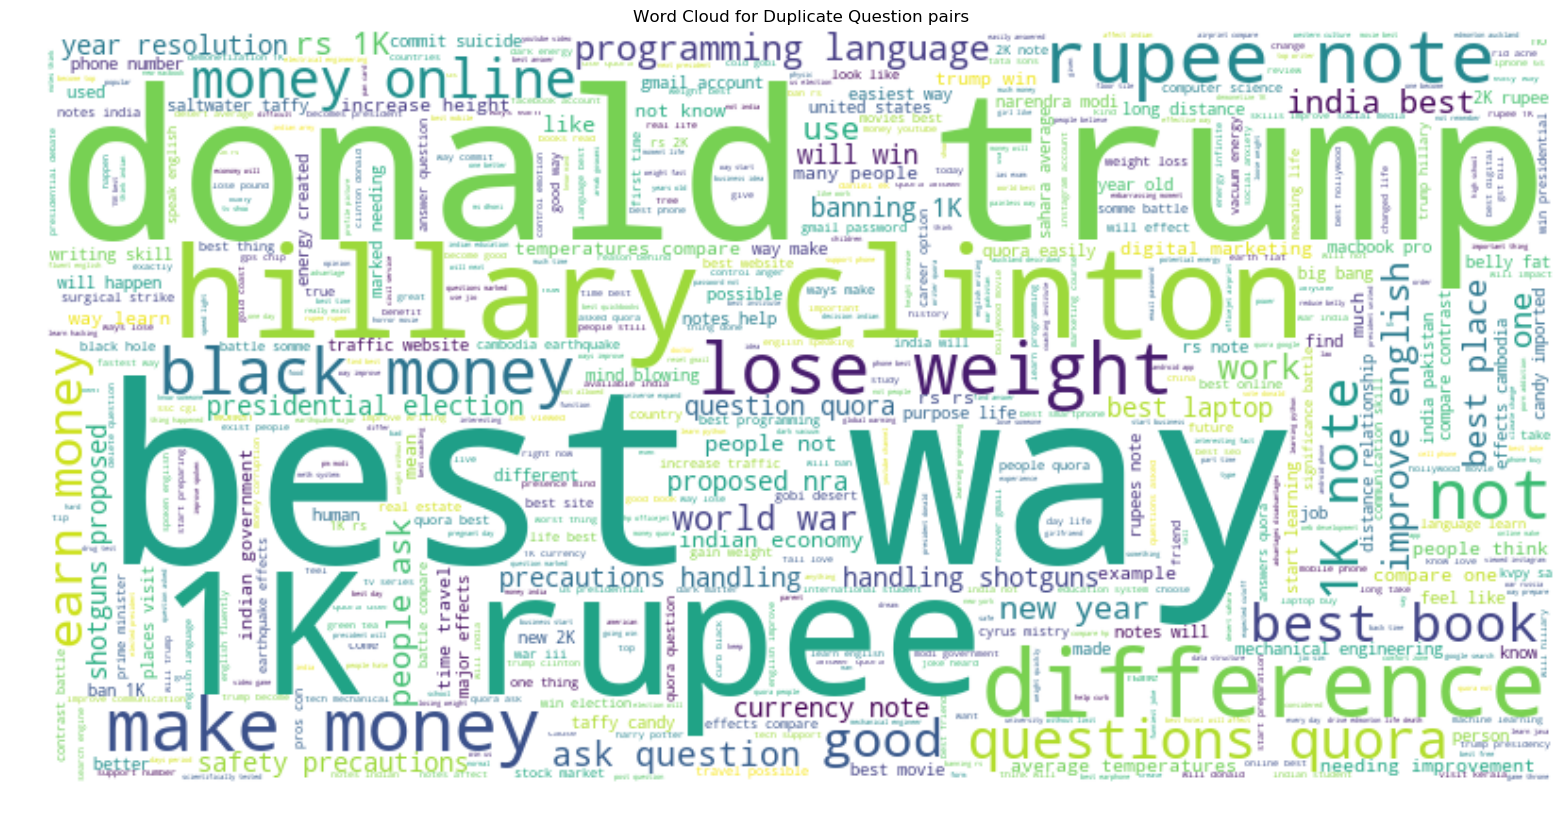

In [35]:
wc = WordCloud(width=800, height=400, background_color="white", max_words=len(text_dup), stopwords=stopwords).generate(text_dup)
plt.figure(figsize=(20, 10), dpi=100)
plt.title("Word Cloud for Duplicate Question pairs")
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

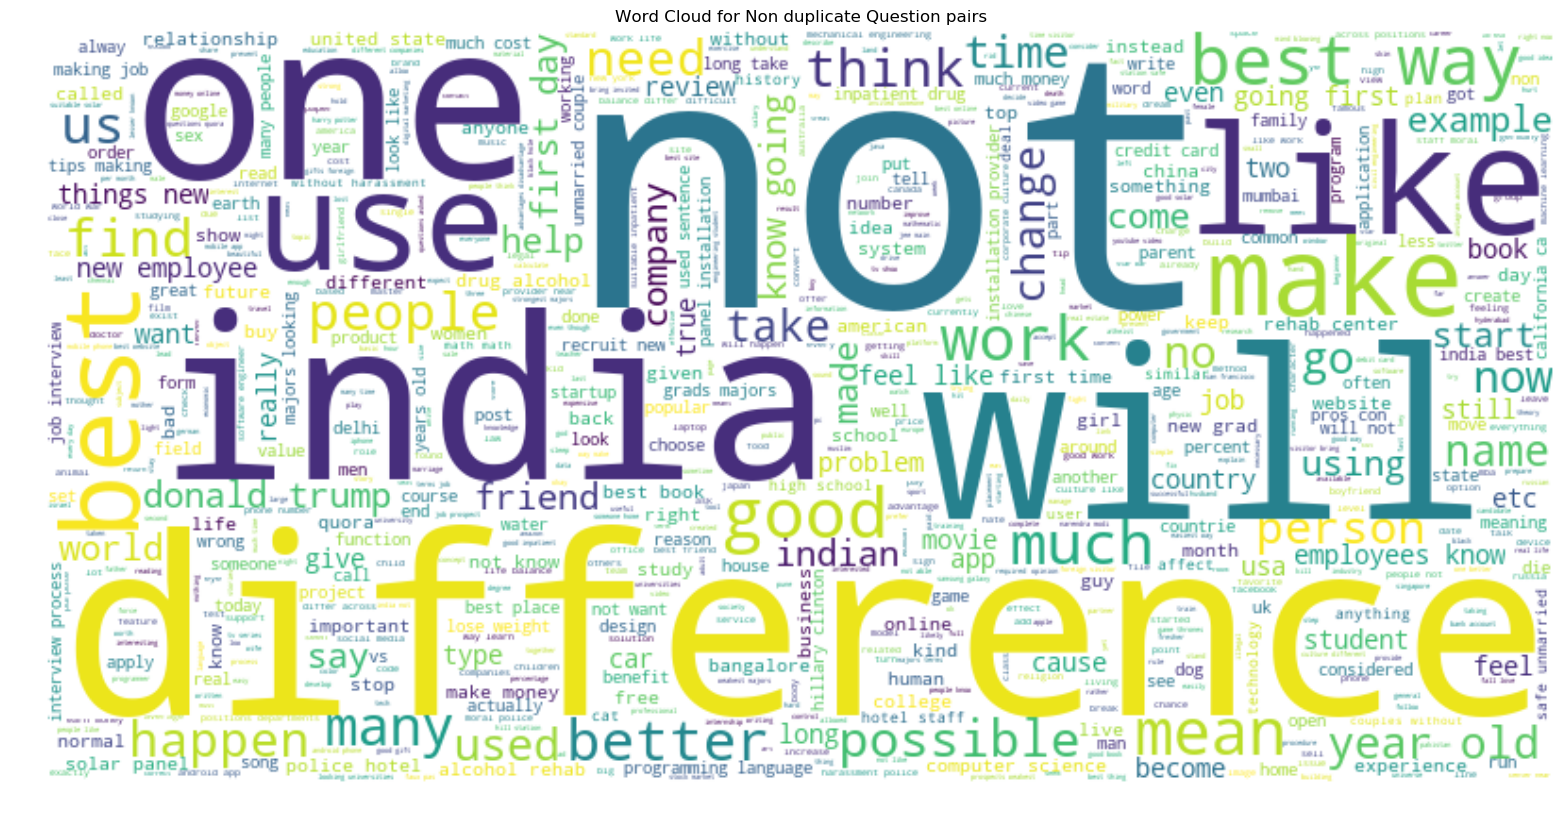

In [36]:
wc = WordCloud(width=800, height=400, background_color="white", max_words=len(text_non_dup), stopwords=stopwords).generate(text_non_dup)
plt.figure(figsize=(20, 10), dpi=100)
plt.title("Word Cloud for Non duplicate Question pairs")
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

<h4> 3.5.1.2 Pair plot of features ['ctc_min', 'cwc_min', 'token_sort_ratio','longest_substr_ratio'] </h4>

In [37]:
df.columns

Index(['id', 'qid1', 'qid2', 'question1', 'question2', 'is_duplicate',
       'cwc_min', 'cwc_max', 'csc_min', 'csc_max', 'ctc_min', 'ctc_max',
       'last_word_eq', 'first_word_eq', 'abs_len_diff', 'mean_len',
       'token_set_ratio', 'token_sort_ratio', 'fuzz_ratio',
       'fuzz_partial_ratio', 'longest_substr_ratio'],
      dtype='object')

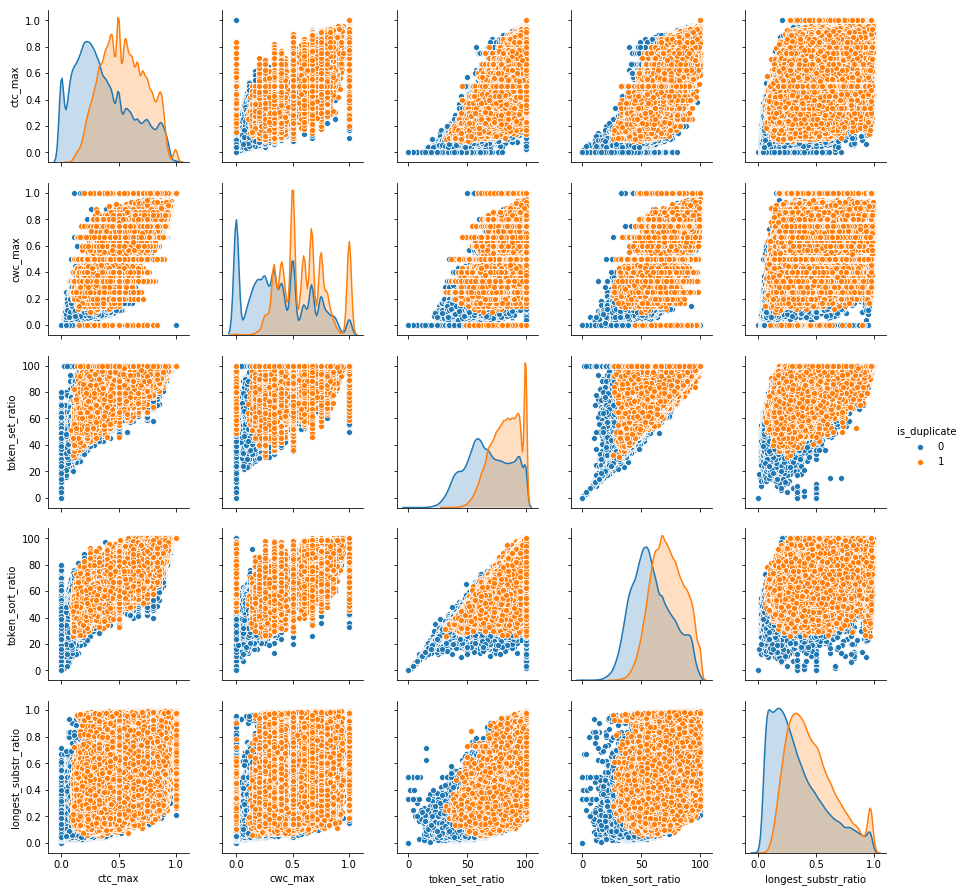

In [38]:
n = df.shape[0]
sns.pairplot(df[['ctc_max', 'cwc_max', 'token_set_ratio', 'token_sort_ratio', 'is_duplicate','longest_substr_ratio']][0:n],
             hue='is_duplicate',
             vars=['ctc_max', 'cwc_max', 'token_set_ratio', 'token_sort_ratio','longest_substr_ratio'])
plt.show()

* The features have some overlap, can be partially seperated they aren't totally useless. 
* The features *'token_sort_ratio', 'is_duplicate', 'longest_substr_ratio'* have some seperation. The other features look less promising.

<h4> 3.5.1.3 Violin plot & Distribution plot : [token_sort_ratio, fuzz_ratio] </h4>

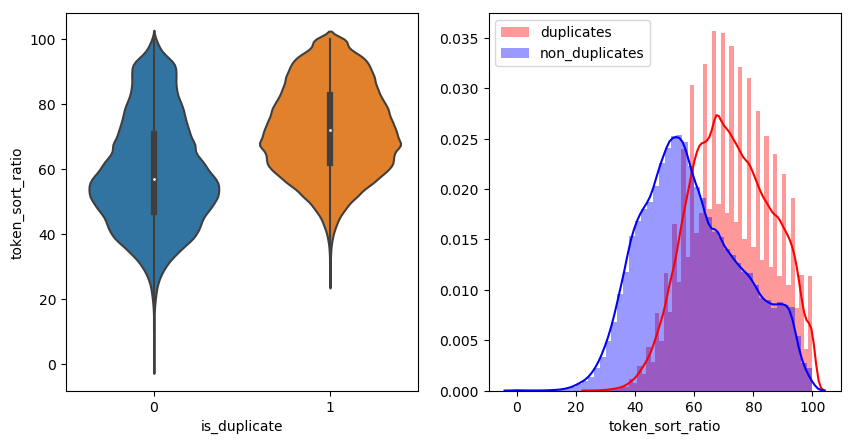

In [40]:
# Distribution of the token_sort_ratio
plt.figure(figsize=(10, 5), dpi=100)
plt.subplot(1, 2, 1)
sns.violinplot(x = 'is_duplicate', y = 'token_sort_ratio', data = df , )

plt.subplot(1, 2, 2)
sns.distplot(df[df['is_duplicate'] == 1.0]['token_sort_ratio'] , label = "duplicates", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['token_sort_ratio'] , label = "non_duplicates" , color = 'blue' )

plt.legend()
plt.show()

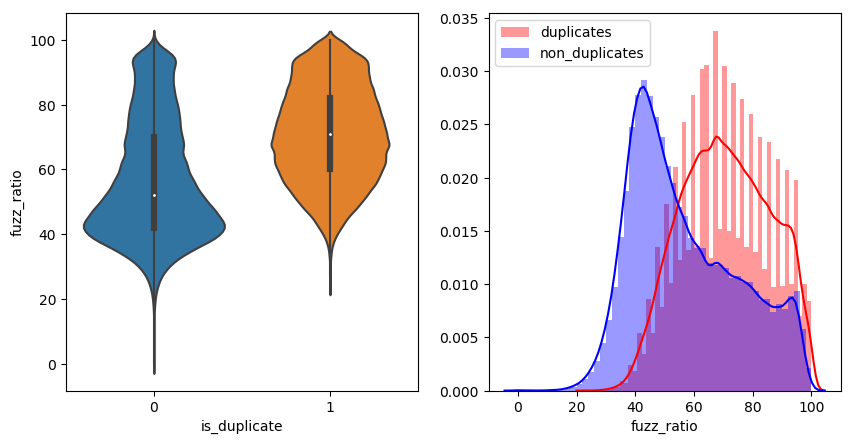

In [41]:
# Distribution of the token_sort_ratio
plt.figure(figsize=(10, 5), dpi=100)

plt.subplot(1, 2, 1)
sns.violinplot(x = 'is_duplicate', y = 'fuzz_ratio', data = df , )

plt.subplot(1, 2, 2)
sns.distplot(df[df['is_duplicate'] == 1.0]['fuzz_ratio'] , label = "duplicates", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['fuzz_ratio'] , label = "non_duplicates" , color = 'blue' )

plt.legend()
plt.show()

* The feature *token_sort_ratio, fuzz_ratio* has some over lap. Both the classes can be partially seperated.
* The distribution of duplicate pairs has greater value and is fatter indicating high similar pairs.

<h3>3.5.2 Visualization </h3>

* We'll use TSNE to project the *advanced engineered features : 15 dim* to 2 dim to see whether they can seperate the duplicates from non_duplicates.

In [42]:
df = pd.read_csv('advanced_features_train.csv')

In [43]:
# Using TSNE for Dimentionality reduction for 15 Features(Generated after cleaning the data) to 3 dimention

from sklearn.preprocessing import MinMaxScaler

#sampling 5K pairs at random, make ou you sample both the classes
df_subsample = df.sample(n=5000)
features = ['cwc_min', 'cwc_max', 'csc_min', 'csc_max', 'ctc_min', 'ctc_max',
            'last_word_eq', 'first_word_eq', 'abs_len_diff', 'mean_len',
            'token_set_ratio', 'token_sort_ratio',  'fuzz_ratio',
            'fuzz_partial_ratio', 'longest_substr_ratio']

X = MinMaxScaler().fit_transform(df_subsample[features])
y = df_subsample['is_duplicate'].values

<h4>3.5.2.1 --> TSNE 2D </h4>

In [44]:
tsne2d = TSNE(n_components=2,
              init='random', # pca
              random_state=101,
              method='barnes_hut',
              n_iter=1000,
              verbose=1,
              angle=0.5).fit_transform(X)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.117s...
[t-SNE] Computed neighbors for 5000 samples in 0.477s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.125109
[t-SNE] KL divergence after 250 iterations with early exaggeration: 67.476929
[t-SNE] KL divergence after 1000 iterations: 0.969371


<Figure size 4000x3000 with 0 Axes>

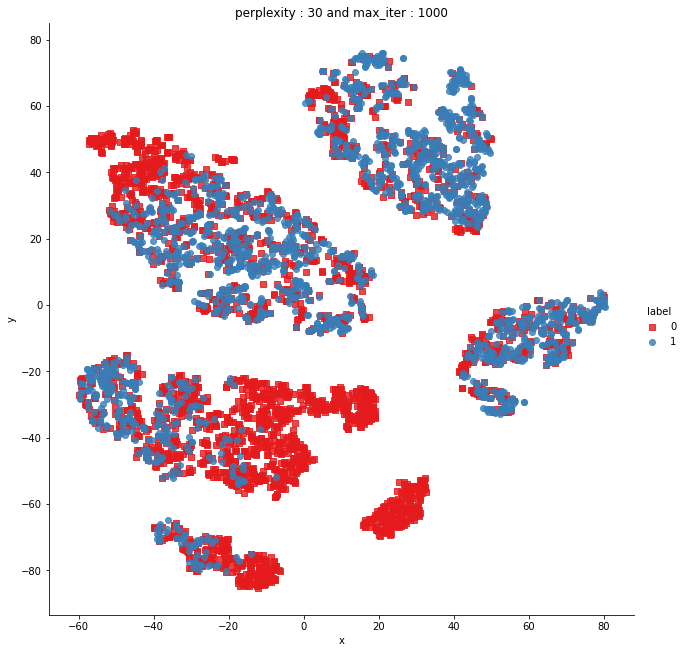

In [45]:
df_tsne2d = pd.DataFrame({'x':tsne2d[:,0], 'y':tsne2d[:,1] , 'label':y})

# draw the plot in appropriate place in the grid
plt.figure(figsize=(20, 15), dpi=200)
sns.lmplot(data=df_tsne2d, x='x', y='y', hue='label', fit_reg=False, size=9, palette="Set1", markers=['s','o'],)
plt.title(f"perplexity : {30} and max_iter : {1000}")
plt.show()

* Looks like the classes are partially seperated, so our advanced feature engineering worked.

<h4>3.5.2.1 --> T-SNE 3D </h4>

In [46]:
tsne3d = TSNE(n_components=3,
              init='random', # pca
              random_state=101,
              method='barnes_hut',
              n_iter=1000,
              verbose=1,
              angle=0.5).fit_transform(X)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.009s...
[t-SNE] Computed neighbors for 5000 samples in 0.434s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.125109
[t-SNE] KL divergence after 250 iterations with early exaggeration: 67.155815
[t-SNE] KL divergence after 1000 iterations: 0.845724


In [2]:
import plotly.plotly as py
import plotly.graph_objs as go
from plotly.tools import set_credentials_file, set_config_file
from PIL import Image

set_config_file(world_readable=True, sharing='public')

__colorscales__:
<pre>
            ['Greys', 'YlGnBu', 'Greens', 'YlOrRd', 'Bluered', 'RdBu',
            'Reds', 'Blues', 'Picnic', 'Rainbow', 'Portland', 'Jet',
            'Hot', 'Blackbody', 'Earth', 'Electric', 'Viridis', 'Cividis']

In [48]:
trace1 = go.Scatter3d(
    x=tsne3d[:,0],
    y=tsne3d[:,1],
    z=tsne3d[:,2],
    mode='markers',
    marker=dict(
        sizemode='diameter',
        color = y,
        colorscale = 'Portland',
        colorbar = dict(title = 'duplicate'),
        line=dict(color='rgb(255, 255, 255)'),
        opacity=0.75
    )
)

data=[trace1]
layout=dict(height=800, width=800, title='3d embedding with engineered features')
fig=dict(data=data, layout=layout)
py.iplot(fig, filename='3DBubble')

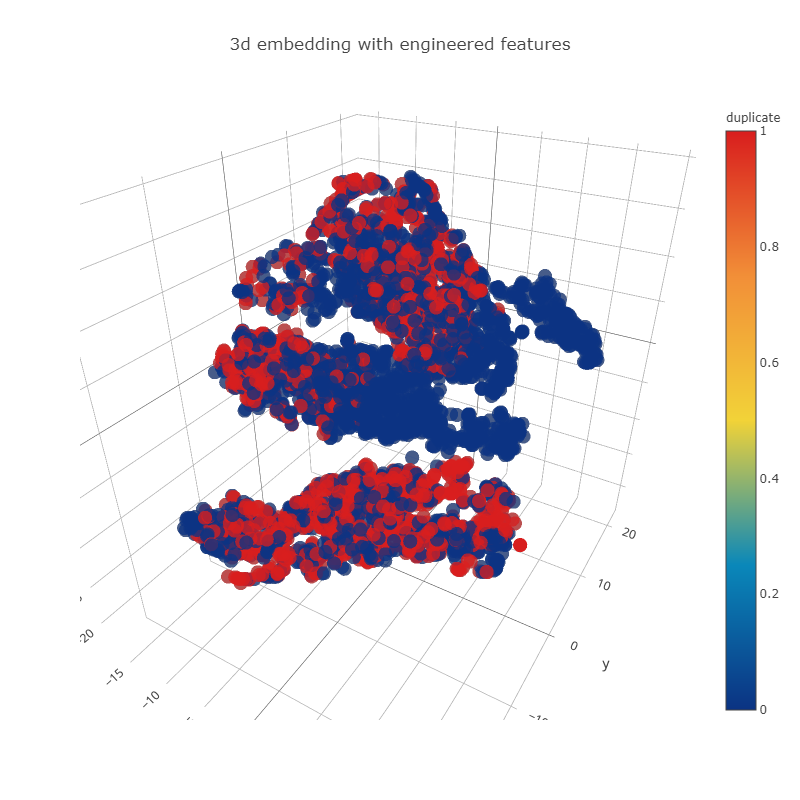

In [3]:
Image.open('newplot.png')

* 3D Plot shows that the classes are partially clustered together.

<h2> 3.6 Featurizing text data with TFIDF weighted GLOVE </h2>

- For each question in question pairs, we'll generate a 300 dim vector representation.
- We'll also verify whether this implementation makes any sense.

In [5]:
df = pd.read_csv('train.csv')
df = df.astype({'question1':str, 'question2':str})

In [6]:
df.head()

id  qid1  qid2                                          question1  \
0   0     1     2  What is the step by step guide to invest in sh...   
1   1     3     4  What is the story of Kohinoor (Koh-i-Noor) Dia...   
2   2     5     6  How can I increase the speed of my internet co...   
3   3     7     8  Why am I mentally very lonely? How can I solve...   
4   4     9    10  Which one dissolve in water quikly sugar, salt...   

                                           question2  is_duplicate  
0  What is the step by step guide to invest in sh...             0  
1  What would happen if the Indian government sto...             0  
2  How can Internet speed be increased by hacking...             0  
3  Find the remainder when [math]23^{24}[/math] i...             0  
4            Which fish would survive in salt water?             0

In [7]:
# merge texts
questions = list(df['question1']) + list(df['question2'])

tfidf = TfidfVectorizer(lowercase=True)
tfidf.fit_transform(questions)

print(f"Number of Unique words : {len(tfidf.get_feature_names())}")

# dict key:word and value:tf-idf score
word_tfidf_map = dict(zip(tfidf.get_feature_names(), tfidf.idf_))

Number of Unique words : 86153


- After we find TF-IDF scores, we convert each question to a weighted average of word2vec vectors by these scores.
- Here we use a pre-trained GLOVE Representations which comes free  https://nlp.stanford.edu/projects/glove/
- It is trained on Wikipedia and therefore, it is stronger in terms of word semantics. 
- Each word in the corpus is represented by a 300D vector. Averaging over all the words in the question, we get a 300 dim vector.

In [8]:
def read_glove_vecs(glove_file):
    
    with open(glove_file, 'r', encoding='utf-8') as f:
        words = set()
        word_to_vec_map = {}
        
        # In each line, the first element is the word and the remaining elements are vectors
        for each_line in f:
            line = each_line.strip().split()   # strip by whitespaces and split into individual elements and store in line
            current_word = line[0]
            words.add(current_word)
            word_to_vec_map[current_word] = np.array(line[1:], dtype=np.float64)
        
        idx = 1
        words_to_index = {}
        index_to_words = {}
        for word in sorted(words):
            words_to_index[word] = idx
            index_to_words[idx] = word
            idx += 1
            
        return words_to_index, index_to_words, word_to_vec_map

In [9]:
word_index_map, index_word_map, word_to_vec_map = read_glove_vecs("glove.6B.300d.txt")

In [10]:
def gen_vec(question):
    q_vec = np.zeros((300, ))
    w_sum = 0.000001
    q_words = question.strip().split()
        
    for word in q_words:
        if (word in word_to_vec_map) and (word in word_tfidf_map):
            tfidf_score = word_tfidf_map[word]
            q_vec += word_to_vec_map[word] * tfidf_score
            w_sum += tfidf_score
            
    return (q_vec / w_sum)

In [11]:
df['q1_vec'] = df['question1'].apply(gen_vec)
df['q2_vec'] = df['question2'].apply(gen_vec)

In [12]:
df.head(2)

id  qid1  qid2                                          question1  \
0   0     1     2  What is the step by step guide to invest in sh...   
1   1     3     4  What is the story of Kohinoor (Koh-i-Noor) Dia...   

                                           question2  is_duplicate  \
0  What is the step by step guide to invest in sh...             0   
1  What would happen if the Indian government sto...             0   

                                              q1_vec  \
0  [-0.05582491761524492, 0.010431264792874656, 0...   
1  [-0.1408509440865006, -0.009215183138669763, 0...   

                                              q2_vec  
0  [-0.02258101988358131, 0.01915795686266648, 0....  
1  [-0.03927516973551398, 0.1725377560216472, -0....

<h3> 3.6.1 Verifying the TFIDF-GLOVE Implementation </h3>

In [15]:
from sklearn.metrics.pairwise import cosine_similarity

def test(idx):
    q1 = df['question1'][idx]
    q2 = df['question2'][idx]
    q1_vec = df.q1_vec[idx].reshape(1, -1)
    q2_vec = df.q2_vec[idx].reshape(1, -1)

    print(f"Question1 : {q1}")
    print(f"Question2 : {q2}")
    print()
    print(f"Is_Duplicate : {bool(df['is_duplicate'][idx])}")
    print()
    print(f"Cosine Similarity(q1, q2) : {np.squeeze(cosine_similarity(q1_vec, q2_vec)) : .3f}")

In [16]:
test(0)

Question1 : What is the step by step guide to invest in share market in india?
Question2 : What is the step by step guide to invest in share market?

Is_Duplicate : False

Cosine Similarity(q1, q2) :  0.983


In [17]:
test(4)

Question1 : Which one dissolve in water quikly sugar, salt, methane and carbon di oxide?
Question2 : Which fish would survive in salt water?

Is_Duplicate : False

Cosine Similarity(q1, q2) :  0.520


In [18]:
test(7)

Question1 : How can I be a good geologist?
Question2 : What should I do to be a great geologist?

Is_Duplicate : True

Cosine Similarity(q1, q2) :  0.899


In [19]:
test(68)

Question1 : What is your review of Performance Testing?
Question2 : What is performance testing?

Is_Duplicate : False

Cosine Similarity(q1, q2) :  0.552


<h3> 3.6.2 Appending the word vectors to engineered features </h3>

In [20]:
df_basic = pd.read_csv("basic_features_train.csv")
df_adv = pd.read_csv("advanced_features_train.csv")

In [21]:
df_basic.head(1)

id  qid1  qid2                                          question1  \
0   0     1     2  What is the step by step guide to invest in sh...   

                                           question2  is_duplicate  freq_qid1  \
0  What is the step by step guide to invest in sh...         False          1   

   freq_qid2  q1_len  q2_len  q1_n_words  q2_n_words  words_common  \
0          1      66      57          14          12          10.0   

   words_total  words_shared  freq_q1+q2  freq_q1-q2  
0         13.0      0.769231           2           0

In [22]:
df_adv.head(1)

id  qid1  qid2                                          question1  \
0   0     1     2  what is the step by step guide to invest in sh...   

                                           question2  is_duplicate  cwc_min  \
0  what is the step by step guide to invest in sh...             0  0.99998   

    cwc_max   csc_min   csc_max          ...            ctc_max  last_word_eq  \
0  0.833319  0.999983  0.999983          ...           0.785709           0.0   

   first_word_eq  abs_len_diff  mean_len  token_set_ratio  token_sort_ratio  \
0            1.0           2.0      13.0              100                93   

   fuzz_ratio  fuzz_partial_ratio  longest_substr_ratio  
0          93                 100              0.982759  

[1 rows x 21 columns]

In [23]:
df_adv2 = df_adv.drop(['qid1','qid2','question1','question2'], axis=1)
df_basic2 = df_basic.drop(['qid1','qid2','question1','question2','is_duplicate'], axis=1)
df3 = df.drop(['qid1','qid2','question1','question2','is_duplicate'], axis=1)

df3_q1 = pd.DataFrame(df3['q1_vec'].values.tolist(), index= df3.index)
df3_q2 = pd.DataFrame(df3['q2_vec'].values.tolist(), index= df3.index)

In [24]:
df_basic2.head()

id  freq_qid1  freq_qid2  q1_len  q2_len  q1_n_words  q2_n_words  \
0   0          1          1      66      57          14          12   
1   1          4          1      51      88           8          13   
2   2          1          1      73      59          14          10   
3   3          1          1      50      65          11           9   
4   4          3          1      76      39          13           7   

   words_common  words_total  words_shared  freq_q1+q2  freq_q1-q2  
0          10.0         13.0      0.769231           2           0  
1           4.0         16.0      0.250000           5           3  
2           4.0         20.0      0.200000           2           0  
3           0.0         19.0      0.000000           2           0  
4           2.0         18.0      0.111111           4           2

In [25]:
df_adv2.head()

id  is_duplicate   cwc_min   cwc_max   csc_min   csc_max   ctc_min  \
0   0             0  0.999980  0.833319  0.999983  0.999983  0.916659   
1   1             0  0.799984  0.399996  0.749981  0.599988  0.699993   
2   2             0  0.399992  0.333328  0.399992  0.249997  0.399996   
3   3             0  0.000000  0.000000  0.000000  0.000000  0.000000   
4   4             0  0.399992  0.199998  0.999950  0.666644  0.571420   

    ctc_max  last_word_eq  first_word_eq  abs_len_diff  mean_len  \
0  0.785709           0.0            1.0           2.0      13.0   
1  0.466664           0.0            1.0           5.0      12.5   
2  0.285712           0.0            1.0           4.0      12.0   
3  0.000000           0.0            0.0           2.0      12.0   
4  0.307690           0.0            1.0           6.0      10.0   

   token_set_ratio  token_sort_ratio  fuzz_ratio  fuzz_partial_ratio  \
0              100                93          93                 100   
1               86                63          66                  75   
2               66                66          54                  54   
3               36                36          35                  40   
4               67                47          46                  56   

   longest_substr_ratio  
0              0.982759  
1              0.596154  
2              0.166667  
3              0.039216  
4              0.175000

In [26]:
df3_q1.head()

0         1         2         3         4         5         6    \
0 -0.055825  0.010431  0.107035 -0.137198 -0.045561  0.022467 -0.104229   
1 -0.140851 -0.009215  0.021778 -0.468995  0.082048  0.281267 -0.310259   
2 -0.230082  0.165987  0.057467 -0.198486 -0.095769 -0.001017  0.034315   
3  0.029018  0.204869 -0.034491 -0.321848  0.204805  0.030789  0.226643   
4 -0.108759  0.160276 -0.077889 -0.263163  0.273702 -0.397223  0.132138   

        7         8         9      ...          290       291       292  \
0  0.105632  0.084146 -1.595813    ...     0.002372 -0.233160 -0.033284   
1  0.048853 -0.175918 -1.396336    ...    -0.018997 -0.113121  0.128657   
2 -0.042312  0.078213 -1.871119    ...    -0.088997 -0.059896 -0.197216   
3  0.250358  0.119823 -1.749052    ...     0.018547 -0.436158  0.125186   
4 -0.059766  0.013301 -1.052218    ...    -0.577994  0.066097 -0.151274   

        293       294       295       296       297       298       299  
0  0.041968  0.198296  0.565832 -0.196102 -0.253620  0.003804 -0.085032  
1  0.148543 -0.069589  0.104201 -0.106157  0.142654 -0.151946  0.077726  
2 -0.075230  0.134495  0.172970 -0.030143 -0.054111 -0.210804 -0.136241  
3  0.045885  0.214387 -0.198121  0.178412 -0.143414 -0.037903  0.107649  
4 -0.125538  0.286968 -0.070323  0.059207 -0.341095 -0.129092  0.051368  

[5 rows x 300 columns]

In [27]:
df3_q2.head()

0         1         2         3         4         5         6    \
0 -0.022581  0.019158  0.155605 -0.175085 -0.093320  0.002616 -0.084738   
1 -0.039275  0.172538 -0.102904  0.175030 -0.121682  0.018965  0.114158   
2 -0.209566  0.155135  0.150674 -0.032348  0.052598  0.050893  0.186710   
3 -0.132793  0.001492  0.228590 -0.068783  0.067382  0.177475  0.085486   
4 -0.009081  0.193235 -0.372845 -0.175296  0.066094  0.219816  0.070926   

        7         8         9      ...          290       291       292  \
0  0.034036  0.086293 -1.496300    ...     0.042149 -0.266782 -0.027568   
1  0.045430 -0.105099 -1.380875    ...     0.057583 -0.279723  0.002448   
2  0.043938  0.234571 -1.856233    ...     0.004293 -0.127778 -0.172033   
3  0.118855  0.022911 -1.284676    ...     0.076861 -0.323471  0.073763   
4  0.207988  0.140546 -1.071095    ...    -0.288960  0.328470  0.110256   

        293       294       295       296       297       298       299  
0  0.010603  0.158274  0.505260 -0.227644 -0.245269  0.031774 -0.143702  
1  0.285735  0.045712  0.194458  0.240915 -0.272939  0.153161  0.179773  
2 -0.003004  0.120612  0.360789 -0.198021 -0.064622 -0.070710 -0.382908  
3  0.022607  0.015884  0.512776  0.074454 -0.426216 -0.035627 -0.303444  
4 -0.130963 -0.091544 -0.355527  0.090180 -0.267737 -0.066930  0.003135  

[5 rows x 300 columns]

In [28]:
print(f"Number of features in Advanced Features Dataframe : {df_adv2.shape[1]}")
print(f"Number of features in Basic Features Dataframe    : {df_basic2.shape[1]}")
print(f"Number of features in question1 w2v  dataframe    : {df3_q1.shape[1]}")
print(f"Number of features in question2 w2v  dataframe    : {df3_q2.shape[1]}")
print(f"Number of features in final dataframe             : {df_adv2.shape[1]+df_basic2.shape[1]+df3_q1.shape[1]+df3_q2.shape[1]}")

Number of features in Advanced Features Dataframe : 17
Number of features in Basic Features Dataframe    : 12
Number of features in question1 w2v  dataframe    : 300
Number of features in question2 w2v  dataframe    : 300
Number of features in final dataframe             : 629


In [29]:
df3_q1['id'] = df_adv2['id']
df3_q2['id'] = df_adv2['id']
df_f = df_adv2.merge(df_basic2, on='id', how='left')
df_q  = df3_q1.merge(df3_q2, on='id', how='left')
final_df = df_f.merge(df_q, on='id',how='left')
final_df.to_csv('final_features.csv', index = False)

In [30]:
final_df.head(1)

id  is_duplicate  cwc_min   cwc_max   csc_min   csc_max   ctc_min  \
0   0             0  0.99998  0.833319  0.999983  0.999983  0.916659   

    ctc_max  last_word_eq  first_word_eq    ...        290_y     291_y  \
0  0.785709           0.0            1.0    ...     0.042149 -0.266782   

      292_y     293_y     294_y    295_y     296_y     297_y     298_y  \
0 -0.027568  0.010603  0.158274  0.50526 -0.227644 -0.245269  0.031774   

      299_y  
0 -0.143702  

[1 rows x 628 columns]

__Please open the second notebook__